In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from scipy.stats import describe
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from numpy.random import *
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.pipeline import FeatureUnion
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from copy import deepcopy


first I clean the data based on interpolation for ticker data and removing -1 data for trades data :

In [21]:
def read_data(obj):
    ## get ticker data
    ticker = pd.read_csv('data/'+obj+'_ticker.csv', index_col=0, header=None)
    ticker.index = pd.to_datetime(ticker.index, unit='s')
    ticker.index.name = None
    ticker.columns = [
        'sell_highest_price', 
        'sell_highest_vol', 
        'buy_highest_price', 
        'buy_highest_vol', 
        'last_trade_price', 
        'daily_trade_vol', 
        'daily_high_price', 
        'daily_low_price'
    ]
    ticker.values[np.where(ticker.values <= 0)] = np.nan
    ticker = ticker.interpolate()
    ## trades data
    trades = pd.read_csv('data/'+obj+'_trades.csv', index_col=0, header=None) 

    ## get book data
    book = pd.read_csv('data/'+obj+'_book.csv', index_col=0, header=None)    
    ticker = ticker.add_suffix(obj)
    return ticker,trades,book


then I define a function that i can give it a time series and get a supervized problem : in here each column of X has name of lag that we have.
then for using nth derivitive of each time I define function data_diff . by this I am gonna find how the trend of data is happening .

In [22]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data,columns,index, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [(columns[j]+'(t-%d)' % (i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [(columns[j]+'(t)')for j in range(n_vars)]
		else:
			names += [(columns[j]+'(t+%d)' % (i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	agg.index = index
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg




In [24]:
def data_diff(data,columns,index, n_in=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.diff(i))
		names += [('diff-'+columns[j]+'(t-%d)' % (i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	agg.index = index
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [25]:
cur_met = 'A'
metals = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
ticker = {'A':[], 'B':[], 'C':[], 'D':[], 'E':[], 'F':[], 'G':[], 'H':[], 'I':[]}
trades = {'A':[], 'B':[], 'C':[], 'D':[], 'E':[], 'F':[], 'G':[], 'H':[], 'I':[]}
book = {'A':[], 'B':[], 'C':[], 'D':[], 'E':[], 'F':[], 'G':[], 'H':[], 'I':[]}
for currency in metals:
    ticker[currency],trades[currency],book[currency] = read_data(currency)

In [26]:
########## get statistics of each 5 min in vopr - price and vol trade 
trades[cur_met].replace(-1,np.NaN)

temp_price_trade = trades[cur_met].iloc[:,3::4]
#price_trade = temp_price_trade.T.describe()
#price_trade = price_trade.drop('count').T
#price_trade['sk']=temp_price_trade.T.skew()
#price_trade['kurt']=temp_price_trade.T.kurtosis()

temp_vol_trade = trades[cur_met].iloc[:,2::4]
#vol_trade = temp_vol_trade.T.describe()
#vol_trade = vol_trade.drop('count').T

temp_vopr_trade = pd.DataFrame(trades[cur_met].iloc[:,3::4].values * trades[cur_met].iloc[:,2::4].values)
#vopr_trade= temp_vopr_trade.T.describe()
#vopr_trade = vopr_trade.drop('count').T
#vopr_trade.index = price_trade.index

temp = np.sum(np.absolute(temp_vopr_trade.get_values()),axis=1) / np.sum(np.absolute(temp_vol_trade.get_values()),axis=1)
absvopr = {'absvopr' : temp}
absvopr = pd.DataFrame.from_dict(absvopr)

*feature generation* : 

In [27]:
### add new feature to ticker
ticker[cur_met]['daily_vollow_price'] = ticker[cur_met]['daily_low_price'+cur_met] * ticker[cur_met]['daily_trade_vol'+cur_met]
ticker[cur_met]['daily_volhigh_price'] = ticker[cur_met]['daily_high_price'+cur_met] * ticker[cur_met]['daily_trade_vol'+cur_met]

I first do some eda on data to find patterns on book and trades data that give me better intution on data . then I generate features based on these EDAs.

In [28]:
### take book data features 
book[cur_met].index = ticker[cur_met].index
price_book  = book[cur_met].iloc[:,::3]
count_book = book[cur_met].iloc[:,1::3]
vol_book = book[cur_met].iloc[:,2::3]
all_book = pd.DataFrame(np.absolute(vol_book.get_values()) * price_book.get_values())
temp = all_book.abs().sum(axis=1).get_values() / ( vol_book.abs().sum(axis=1).get_values())
mp_book = {'mp_book' : temp}
mp_book = pd.DataFrame.from_dict(mp_book)


first I run a random forrest on hule data and features find most important features . and then I remove unimportant features :

In [29]:
K = 10
### set index of dataframe to time and merger data 
absvopr.index = ticker[cur_met].index
mp_book.index = ticker[cur_met].index
### merge step ticker and trade
imp_ticker = ticker[cur_met].iloc[:,[0,2,4,7]]    
#stock = pd.merge(ticker,vopr_trade, left_index=True, right_index=True)
stock = pd.DataFrame(index=ticker[cur_met].index)
stock = pd.merge(imp_ticker,absvopr, left_index=True, right_index=True) ## y
#stock = pd.merge(stock,vol_trade, left_index=True, right_index=True) ## x
stock = pd.merge(stock,mp_book, left_index=True, right_index=True) ## y
other_stock = pd.DataFrame(index=ticker[cur_met].index)
for currency in metals:
    if(currency!=cur_met):
        ticker[currency].index = ticker[cur_met].index
        temp_tic = ticker[currency].iloc[:,:]
        other_stock = pd.merge(other_stock,temp_tic, left_index=True, right_index=True)
other_stock.head()

,sell_highest_priceB,sell_highest_volB,buy_highest_priceB,buy_highest_volB,last_trade_priceB,daily_trade_volB,daily_high_priceB,daily_low_priceB,sell_highest_priceC,sell_highest_volC,...,daily_high_priceH,daily_low_priceH,sell_highest_priceI,sell_highest_volI,buy_highest_priceI,buy_highest_volI,last_trade_priceI,daily_trade_volI,daily_high_priceI,daily_low_priceI
2017-11-13 06:47:52.005880000,81.892978,370.539968,81.918736,1214.253394,81.886538,116052.638411,86.291256,79.980403,35.543799,233.071195,...,33.41931,31.006682,23.311152,42833.483979,23.324578,26967.599987,23.311152,5.007051e+06,25.499665,23.076189
2017-11-13 06:52:57.527236999,81.899417,932.577618,81.925176,863.061274,81.886538,116288.844825,86.291256,79.980403,35.546386,711.976232,...,33.41931,31.006682,23.335767,40046.584085,23.380522,24791.365377,23.364858,5.023152e+06,25.499665,23.076189
2017-11-13 06:57:58.085662000,81.789943,542.775734,81.809262,1041.552825,81.815702,116285.294380,86.291256,79.980403,35.505860,237.014116,...,33.41931,31.006682,23.006819,28733.550972,23.103042,33743.472823,23.103042,5.243893e+06,25.499665,22.825562
2017-11-13 07:02:57.098389000,81.796383,363.280927,81.809262,1042.962178,81.802822,115899.637079,86.291256,79.980403,35.498100,149.924697,...,33.41931,31.006682,23.022483,49936.354487,23.091853,31601.676881,23.022483,5.256865e+06,25.499665,22.825562
2017-11-13 07:07:57.429270000,81.616073,395.477433,81.622512,1153.703546,81.622512,115720.433592,86.291256,79.980403,35.484304,192.284731,...,33.41931,31.006682,23.136608,46736.265644,23.138846,29467.498695,23.136608,5.252237e+06,25.499665,22.825562


In [30]:
all_feat = [u'sell_highest_price',
 u'buy_highest_price',
 u'last_trade_price',]
all_feat = [x+cur_met for x in all_feat]
all_feat.append(u'absvopr')

In [31]:
#list(range(stock.shape[1]))#[0,2,4,7] #+ [9,10,14,16,17,21,23,24,28]
temp_stock = stock.loc[:,all_feat];
data_stock_raw = series_to_supervised(temp_stock.values,temp_stock.columns.get_values(),temp_stock.index,25, 11)
#other_data_raw = series_to_supervised(other_stock.values,other_stock.columns.get_values(),other_stock.index,0, 1)
other_data_raw = other_stock
#data_diffren = data_diff(temp_stock.values,temp_stock.columns.get_values(),temp_stock.index,20)
other_data_raw.head()


,sell_highest_priceB,sell_highest_volB,buy_highest_priceB,buy_highest_volB,last_trade_priceB,daily_trade_volB,daily_high_priceB,daily_low_priceB,sell_highest_priceC,sell_highest_volC,...,daily_high_priceH,daily_low_priceH,sell_highest_priceI,sell_highest_volI,buy_highest_priceI,buy_highest_volI,last_trade_priceI,daily_trade_volI,daily_high_priceI,daily_low_priceI
2017-11-13 06:47:52.005880000,81.892978,370.539968,81.918736,1214.253394,81.886538,116052.638411,86.291256,79.980403,35.543799,233.071195,...,33.41931,31.006682,23.311152,42833.483979,23.324578,26967.599987,23.311152,5.007051e+06,25.499665,23.076189
2017-11-13 06:52:57.527236999,81.899417,932.577618,81.925176,863.061274,81.886538,116288.844825,86.291256,79.980403,35.546386,711.976232,...,33.41931,31.006682,23.335767,40046.584085,23.380522,24791.365377,23.364858,5.023152e+06,25.499665,23.076189
2017-11-13 06:57:58.085662000,81.789943,542.775734,81.809262,1041.552825,81.815702,116285.294380,86.291256,79.980403,35.505860,237.014116,...,33.41931,31.006682,23.006819,28733.550972,23.103042,33743.472823,23.103042,5.243893e+06,25.499665,22.825562
2017-11-13 07:02:57.098389000,81.796383,363.280927,81.809262,1042.962178,81.802822,115899.637079,86.291256,79.980403,35.498100,149.924697,...,33.41931,31.006682,23.022483,49936.354487,23.091853,31601.676881,23.022483,5.256865e+06,25.499665,22.825562
2017-11-13 07:07:57.429270000,81.616073,395.477433,81.622512,1153.703546,81.622512,115720.433592,86.291256,79.980403,35.484304,192.284731,...,33.41931,31.006682,23.136608,46736.265644,23.138846,29467.498695,23.136608,5.252237e+06,25.499665,22.825562


In [32]:
data_stock_raw.shape

(11166, 144)

I use diffrent models to find best cross validation error on data and diffrent features that I used before:

In [33]:
#### my models galery :) 
lasso = linear_model.Lasso()
rig = Ridge(alpha=2)
lin = LinearRegression()
f_model2 =ExtraTreesRegressor(n_estimators=100, max_features=50,
                                       random_state=0)
f_model1 =ExtraTreesRegressor(n_estimators=100, max_features=50,
                                       random_state=0)
model = RandomForestRegressor(n_estimators=20, random_state=1)
logisticRegr = LogisticRegression(C=0.1,  
                           max_iter=20, 
                           fit_intercept=True, 
                           n_jobs=-1, 
                           solver='liblinear')
ada_model = AdaBoostRegressor(base_estimator=LinearRegression(), loss='exponential')
adam_model = AdaBoostRegressor(base_estimator=f_model1, loss='exponential')
svr = SVR(kernel='rbf', C=1e3, gamma=0.1)

# create feature union
# create pipeline
estimators = []
estimators.append(('feature_selection', SelectFromModel(f_model1)))
estimators.append(('lin', f_model2))
pip = Pipeline(estimators)

in here I choose witch feature to use :

In [34]:
#### set feature name 
input_feat = temp_stock.columns
past_feat = [0,1,10]
input_names = []
for i in past_feat:
    if (i==0):
        input_names += [(input_feat[j]+'(t)')for j in range(len(input_feat))]
    else:
         input_names += [(input_feat[j]+'(t-%d)' % (i))for j in range(len(input_feat))]

#diff_feat =[1,2]
#diff_names = []
#for i in diff_feat:
#    diff_names += [('diff-'+input_feat[j]+'(t-%d)' % (i)) for j in range(len(input_feat))]
    
#input_names += diff_names

output_feat = temp_stock.columns[2]
fut_feat = list(range(10))
fut_feat = []
for i in range(1,11):
     temp = []
     temp.append(output_feat+'(t+%d)' % (i))
     fut_feat.append(temp)

adding other stock data to raw stock data :

In [35]:
data =  pd.concat([other_data_raw, data_stock_raw.loc[:,input_names]], axis=1, join='inner')
data.head()

,sell_highest_priceB,sell_highest_volB,buy_highest_priceB,buy_highest_volB,last_trade_priceB,daily_trade_volB,daily_high_priceB,daily_low_priceB,sell_highest_priceC,sell_highest_volC,...,last_trade_priceA(t),absvopr(t),sell_highest_priceA(t-1),buy_highest_priceA(t-1),last_trade_priceA(t-1),absvopr(t-1),sell_highest_priceA(t-10),buy_highest_priceA(t-10),last_trade_priceA(t-10),absvopr(t-10)
2017-11-13 08:52:58.107389,81.191056,466.093478,81.223254,829.498297,81.191056,107025.733073,86.291256,79.980403,35.366175,418.269665,...,69.877151,69.760374,69.386305,69.387372,69.302008,69.484474,70.206870,70.207938,70.197267,70.123346
2017-11-13 08:58:00.106485,81.203935,721.797127,81.210375,622.015168,81.203935,106954.146469,86.291256,79.980403,35.340307,311.505994,...,69.838737,69.958123,69.876083,69.877151,69.877151,69.760374,70.267693,70.268760,70.268760,70.226169
2017-11-13 09:02:57.060709,80.965669,553.844954,80.972108,295.606153,80.972108,106758.488878,86.291256,79.980403,35.255806,158.226028,...,69.659471,69.852841,69.824865,69.838737,69.838737,69.958123,70.108701,70.111903,70.179127,69.981522
2017-11-13 09:07:58.085158,80.952789,686.232097,81.062263,607.938402,81.081582,106652.758497,86.291256,79.980403,35.245459,169.480834,...,69.650935,69.622181,69.659471,69.663740,69.659471,69.852841,69.559168,69.613588,69.609320,69.532790
2017-11-13 09:12:57.084185,80.927031,767.644856,80.997867,769.257271,80.946350,106317.921652,86.291256,79.980403,35.339445,391.576589,...,69.734165,69.723012,69.659471,69.673343,69.650935,69.622181,69.475938,69.491944,69.471670,69.592144


In [36]:
import pickle
import sys
p = pickle.dumps(pip)
print(sys.getsizeof(p))

1240


In [ ]:
cv_k= np.zeros([K,1])
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_t = data.get_values()
X_t = StandardScaler().fit_transform(X_t)
X_t = poly.fit_transform(X_t)
Y = data_stock_raw.loc[:,sum(fut_feat, [])].get_values()
cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0)
np.mean(cross_val_score(pip, X_t,Y, cv=cv,n_jobs=-1,scoring='neg_mean_squared_error'))


In [44]:
X_t = data.loc[:,input_names].get_values()
X_t.shape

(11166, 12)

*find out how good my prediction is and where error is happening :*

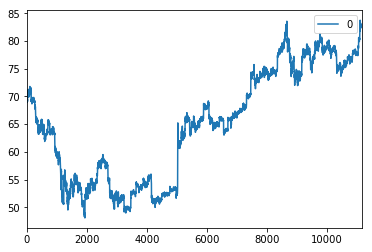

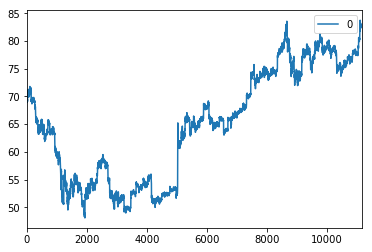

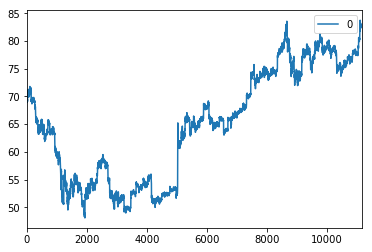

In [49]:
X_t = data.loc[:,input_names].get_values()
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_t = StandardScaler().fit_transform(X_t)
X_t = poly.fit_transform(X_t)
Y = data_stock_raw.loc[:,fut_feat[0]].get_values()
f_model1.fit(X_t,np.ravel(Y))
yplot = DataFrame(Y)
yplot.plot()
yplot = DataFrame(f_model1.predict(X_t))
yplot.plot()
plt.show()

*find importanty features by feature importance*
it seems that near value data are much more important than far features .

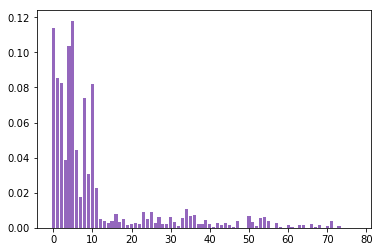

In [61]:
# plot importance scores
ticks = list(range(78)) 
plt.bar(ticks, f_model1.feature_importances_)
plt.show()

*some EDA on Book data *
plot histogram of absoloute value of price * volume to find any pattern :

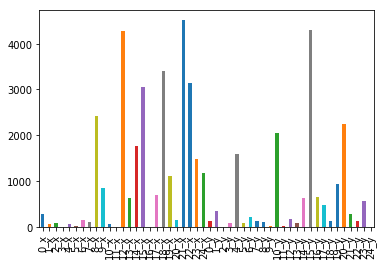

In [56]:
tall = pd.merge(aall_book,ball_book, left_index=True, right_index=True)
df2 = tall.iloc[10,:].T
plt.figure()
df2.plot.bar()
plt.show()

*find out how trades are happening in case of each 5 min and where last price comes on this trades * 

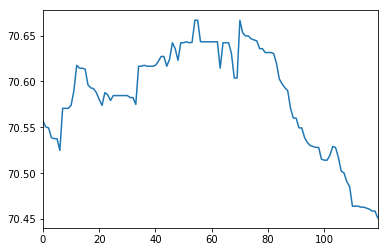

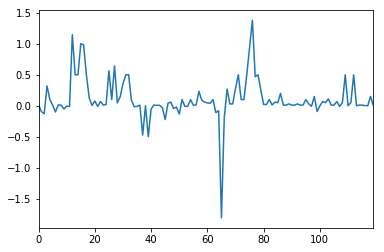

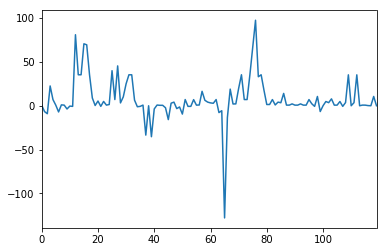

2017-11-13 06:47:52.005880000     85.097402
2017-11-13 06:52:57.527236999     49.160407
2017-11-13 06:57:58.085662000     24.890509
2017-11-13 07:02:57.098389000     26.787416
2017-11-13 07:07:57.429270000     39.864839
2017-11-13 07:12:57.096186000     38.047741
2017-11-13 07:17:57.096133000     39.548353
2017-11-13 07:22:57.322941000     38.636847
2017-11-13 07:27:57.149332000     48.984871
2017-11-13 07:32:57.085762000     32.589320
2017-11-13 07:37:57.350605000     51.354244
2017-11-13 07:42:57.196558000     62.501000
2017-11-13 07:47:58.331846000     50.634428
2017-11-13 07:52:59.552217000     64.243357
2017-11-13 07:59:01.837357000     39.001069
2017-11-13 08:02:57.321622000     23.411397
2017-11-13 08:07:57.707800000     35.494869
2017-11-13 08:12:57.315138000     54.950925
2017-11-13 08:17:57.076812000     58.556392
2017-11-13 08:22:58.116854000     82.373487
2017-11-13 08:27:57.075746000     31.450078
2017-11-13 08:32:57.083999000     74.559469
2017-11-13 08:37:57.402627000   

In [64]:
i = 0
ls_p = ticker['A'].iloc[:,3]
q_min = np.argmin(np.absolute([temp_price_trade.iloc[i,:]-ls_p]))
df1 = pd.concat([temp_price_trade.iloc[i,:] ])
df2 = pd.concat([temp_vol_trade.iloc[i,:] ])
df3 = pd.concat([temp_vopr_trade.iloc[i,:] ])
df1.index = np.arange(120)
df2.index = np.arange(120)
df3.index = np.arange(120)

plt.figure()
df1.plot()
#df2.plot.hist()
#plt.plot([ls_p,ls_p],[1,10],'k-', lw=2)
plt.figure()
df2.plot()
plt.figure()
df3.plot()
plt.show()
print (ls_p)
print(sum(np.absolute(temp_vopr_trade.iloc[i,:])) /sum(np.absolute(temp_vol_trade.iloc[i,:])))

*by correlation plot i find features that are mot realated to last price * 

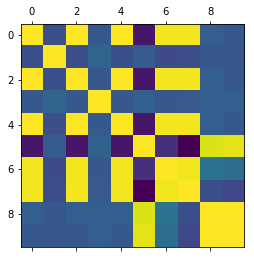

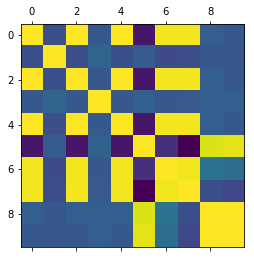

In [66]:
plt.matshow(ticker['A'].corr())
plt.show()